In [2]:
import pandas as pd
import matplotlib.pyplot as plt

logs = # TO FILL
processed_log_dir = f"{logs}/resultats_11-23_processed"
save_dir = f"{processed_log_dir}/bert/"

job_file = save_dir+"/summary.csv"
energy_file = save_dir+"/energy.csv"
jobs = pd.read_csv(job_file).drop(columns=["Unnamed: 0"])

In [3]:
jobs.columns

Index(['job', 'energy_kWh', 'energy_joule',
       'energy_consumption_since_previous_measurement_milliJ', 'job_id',
       'file', 'sub_seed', 'sub_batch-size', 'sub_num-sample',
       'sub_target-acc', 'sub_grad_step', 'srun_start_time_ms',
       'start_time_ms', 'cmd_cpu', 'cmd_ib', 'cmd_mem', 'cmd_train_batch_size',
       'cmd_learning_rate', 'cmd_opt_lamb_beta_1', 'cmd_opt_lamb_beta_2',
       'cmd_warmup_proportion', 'cmd_warmup_steps', 'cmd_start_warmup_step',
       'cmd_max_steps', 'cmd_max_seq_length', 'cmd_max_predictions_per_seq',
       'cmd_input_dir', 'cmd_init_checkpoint',
       'cmd_train_mlm_accuracy_window_size', 'cmd_target_mlm_accuracy',
       'cmd_weight_decay_rate', 'cmd_max_samples_termination',
       'cmd_eval_iter_start_samples', 'cmd_eval_iter_samples',
       'cmd_eval_batch_size', 'cmd_eval_dir', 'cmd_output_dir',
       'cmd_dwu-num-rs-pg', 'cmd_dwu-num-ar-pg', 'training_start_time_ms',
       'train_end_time_ms', 'end_time_ms', 'epoch_nb', 'block_nb

In [9]:
cols = ['mllog_eval_accuracy','energy_kWh','node_nb',  'mllog_gradient_accumulation_steps', 'sub_seed','block_nb', 'sub_batch-size', 
        'mllog_train_samples', 'sub_num-sample', 'sub_target-acc', 'sub_grad_step',
       'total_batch_size', 'images_processed',
        'cmd_train_batch_size','cmd_learning_rate', 'cmd_max_steps', 
        'eval_nb',
        'mllog_global_batch_size', 'mllog_d_batch_size',
        'mllog_opt_learning_rate_training_steps', 'mllog_opt_base_learning_rate',
       'mllog_eval_samples', 
        ]

In [10]:
pd.set_option('display.max_colwidth', 15)
pd.set_option('display.max_rows', 67)
jobs[cols].style.background_gradient(cmap='viridis', low=0.2, high=0.2, axis=0)

,mllog_eval_accuracy,energy_kWh,node_nb,mllog_gradient_accumulation_steps,sub_seed,block_nb,sub_batch-size,mllog_train_samples,sub_num-sample,sub_target-acc,sub_grad_step,total_batch_size,images_processed,cmd_train_batch_size,cmd_learning_rate,cmd_max_steps,eval_nb,mllog_global_batch_size,mllog_d_batch_size,mllog_opt_learning_rate_training_steps,mllog_opt_base_learning_rate,mllog_eval_samples
0,0.720324,1.149060,1,1,51,7846,48,3003264,14000000,0.720000,nan,384,3012864,48,0.000380,9999,20,384,48,9999.000000,0.000380,10000
1,0.720324,1.149335,1,1,51,7846,48,3003264,14000000,0.720000,nan,384,3012864,48,0.000380,9999,20,384,48,9999.000000,0.000380,10000
2,0.720324,1.147483,1,1,51,7846,48,3003264,14000000,0.720000,nan,384,3012864,48,0.000380,9999,20,384,48,9999.000000,0.000380,10000
3,0.720324,1.147789,1,1,51,7846,48,3003264,14000000,0.720000,nan,384,3012864,48,0.000380,9999,20,384,48,9999.000000,0.000380,10000
4,0.720324,1.148737,1,1,51,7846,48,3003264,14000000,0.720000,nan,384,3012864,48,0.000380,9999,20,384,48,9999.000000,0.000380,10000
5,0.720324,1.149066,1,1,51,7846,48,3003264,14000000,0.720000,nan,384,3012864,48,0.000380,9999,20,384,48,9999.000000,0.000380,10000
6,0.720196,1.229170,1,2,51,15677,48,3005184,14000000,0.720000,nan,192,6019968,48,0.000380,9999,20,384,24,9999.000000,0.000380,10000
7,0.720397,1.161821,1,1,6,7843,48,3002880,14000000,0.720000,nan,384,3011712,48,0.000380,9999,20,384,48,9999.000000,0.000380,10000
8,0.720149,1.244017,1,2,6,15674,48,3005184,14000000,0.720000,nan,192,6018816,48,0.000380,9999,20,384,24,9999.000000,0.000380,10000
9,0.720196,1.127473,1,1,42,7451,48,2852736,14000000,0.720000,nan,384,2861184,48,0.000380,9999,19,384,48,9999.000000,0.000380,10000


# Conducted experiments

In [11]:
cols=['cmd_learning_rate', 'cmd_max_steps']
gp_by = ["node_nb", "mllog_gradient_accumulation_steps", "total_batch_size", "sub_num-sample", "sub_target-acc","sub_seed"] # "sub_seed" 
jobs[gp_by+["job_id"]].groupby(gp_by).first()["job_id"]

node_nb  mllog_gradient_accumulation_steps  total_batch_size  sub_num-sample  sub_target-acc  sub_seed
1        1                                  384               14000000        0.72            6           126231
                                                                                              42          126233
                                                                                              51          126224
         2                                  192               14000000        0.72            6           126232
                                                                                              42          126234
                                                                                              51          126230
2        1                                  768               14000000        0.72            6           126738
                                                                                              51          

We tested several values for the number of samples (sub_num-sample) and the target accuracy (sub_target-acc). The batch size is not identical for each node number.

In [4]:
jobs[gp_by+["eval_nb"]].groupby(gp_by).mean()["eval_nb"]

node_nb  mllog_gradient_accumulation_steps  sub_batch-size  sub_num-sample  sub_target-acc  sub_seed
1        1                                  48              14000000        0.72            6           20.0
                                                                                            42          19.0
                                                                                            51          20.0
         2                                  48              14000000        0.72            6           20.0
                                                                                            42          16.0
                                                                                            51          20.0
2        1                                  48              14000000        0.72            6           19.0
                                                                                            51          20.0
Name: eval_nb, dtype: float

It seems that the execution with a dataset of 225000 didn't go well - only one evaluation was done.

# Preprocessing

In [7]:
# jobs["sub_num-sample"] = jobs["sub_num-sample"].fillna(14000000)
jobs["cmd_train_batch_size"] = jobs["cmd_train_batch_size"].astype(int)
jobs["cmd_max_samples_termination"] = jobs["cmd_max_samples_termination"].astype(int)

# Computing the total number of images processed, which seems like the most relevant metric regarding energy consumption
jobs["total_batch_size"]=jobs["mllog_d_batch_size"]*jobs["node_nb"]*8
jobs["images_processed"] = jobs["block_nb"]*jobs["mllog_global_batch_size"]

# Result exploration

In [26]:
(jobs["energy_kWh"].max()-jobs["energy_kWh"].min())/jobs["energy_kWh"].max()
# diff de 5% entre le max et le min


0.20710608053765553

/Users/mathildepro/miniforge3/envs/energy_analysis/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1500x800 with 0 Axes>

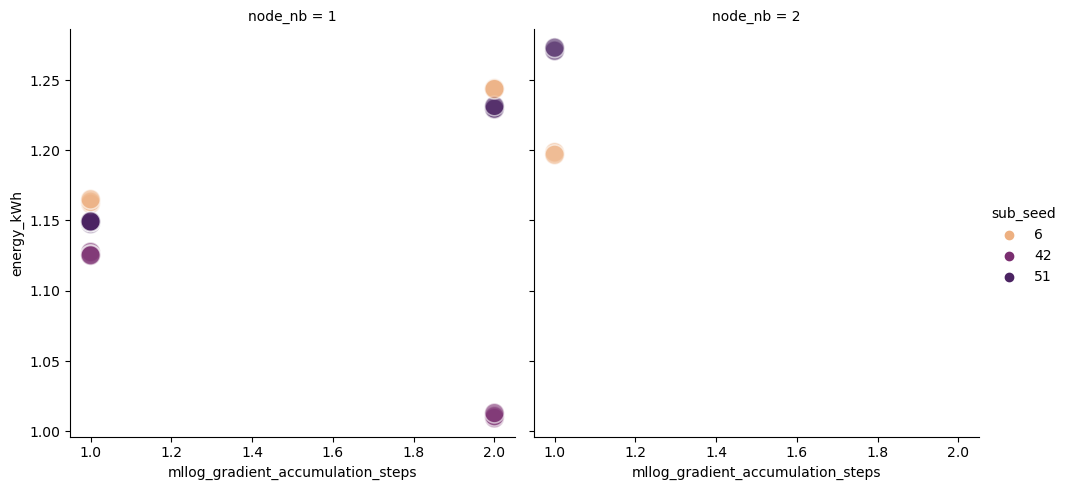

In [6]:
import seaborn as sns
plt.figure(figsize=(15,8))
sns.relplot(
    data=jobs,
    x="mllog_gradient_accumulation_steps", y="energy_kWh", col="node_nb", hue="sub_seed", s=200, alpha=0.6, palette="flare"
)

/Users/mathildepro/miniforge3/envs/energy_analysis/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1500x800 with 0 Axes>

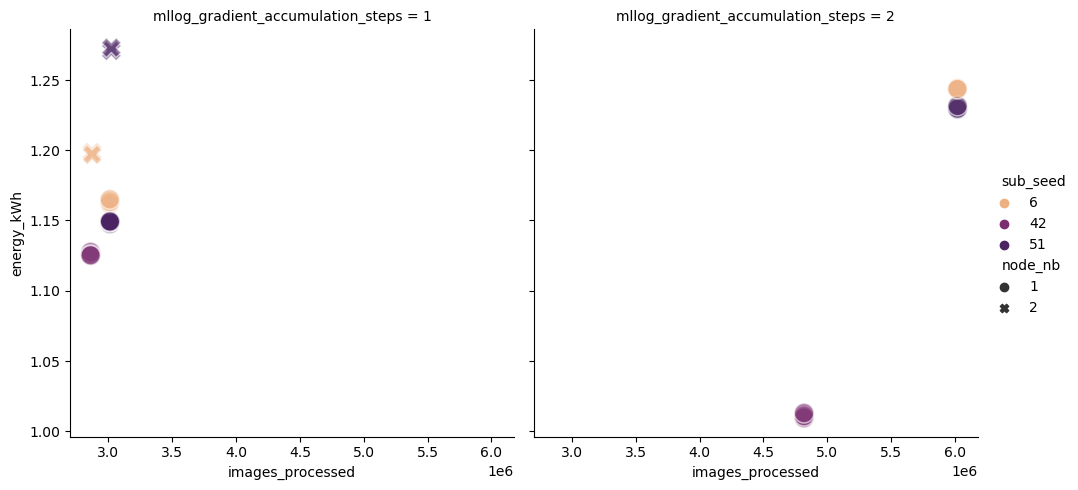

In [7]:
import seaborn as sns
plt.figure(figsize=(15,8))
sns.relplot(
    data=jobs,
    x="images_processed", y="energy_kWh",style="node_nb", col="mllog_gradient_accumulation_steps", hue="sub_seed", s=200, alpha=0.6, palette="flare"
)

# Accuracy
mllog_eval_accuracy, mllog_train_samples, images_processed, epoch_nb, block_nb, eval_nb

/Users/mathildepro/miniforge3/envs/energy_analysis/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1500x800 with 0 Axes>

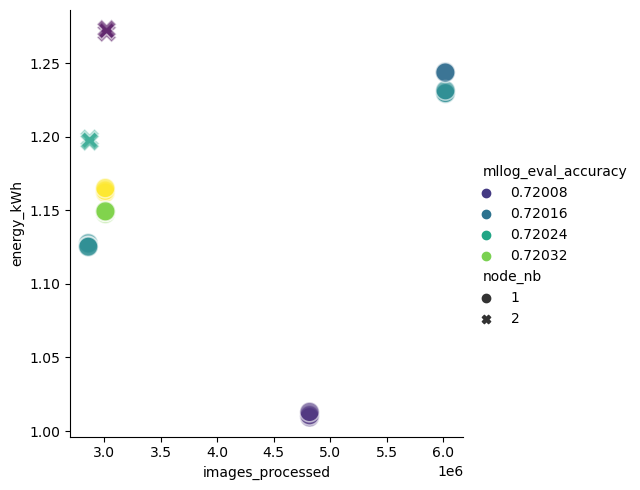

In [8]:
les_x = "images_processed"

plt.figure(figsize=(15,8))
sns.relplot(
    data=jobs,
    x=les_x, y="energy_kWh", hue="mllog_eval_accuracy", style="node_nb", s=200, alpha=0.6, palette="viridis"
)

## MLLOGS details

In [2]:
list(jobs.job)

[126224,
 126225,
 126226,
 126227,
 126228,
 126229,
 126230,
 126231,
 126232,
 126233,
 126234,
 126235,
 126236,
 126237,
 126238,
 126239,
 126240,
 126241,
 126242,
 126243,
 126244,
 126245,
 126246,
 126737,
 126738,
 126739,
 126740]

In [4]:
plot_df = jobs[(jobs["job"]==126224)]

file = plot_df.file.values[0]
file.split("/")[-2:]
path = '/Users/mathildepro/Documents/code_projects/hpe_logs/resultats_nov/bert/'

log_file = path + "/".join(file.split("/")[-2:])
print(log_file)


/Users/mathildepro/Documents/code_projects/hpe_logs/resultats_nov/bert/126224/231106120404308894939_1.log


In [5]:

import sys
sys.path.append("/Users/mathildepro/Documents/code_projects/ai-energy-consumption-framework/ML_benchmark/visualise_results/logging/mlperf_logging/")
# /Users/mathildepro/Documents/code_projects/ai-energy-consumption-framework/ML_benchmark/visualise_results/logging/mlperf_logging/compliance_checker/mlp_parser
from mlperf_logging.compliance_checker.mlp_parser import parse_file
loglines, _ = parse_file(log_file, ruleset="2.1.0")
mllog = pd.DataFrame(loglines)
mllog

,full_string,timestamp,key,value,lineno
0,":::MLLOG {""namespace"": """", ""time_ms"": 16992687...",1.699269e+12,init_start,"{'value': None, 'metadata': {'file': '/workspa...",0
1,":::MLLOG {""namespace"": """", ""time_ms"": 16992687...",1.699269e+12,init_start,"{'value': None, 'metadata': {'file': '/workspa...",1
2,":::MLLOG {""namespace"": """", ""time_ms"": 16992687...",1.699269e+12,init_start,"{'value': None, 'metadata': {'file': '/workspa...",2
3,":::MLLOG {""namespace"": """", ""time_ms"": 16992687...",1.699269e+12,init_start,"{'value': None, 'metadata': {'file': '/workspa...",3
4,":::MLLOG {""namespace"": """", ""time_ms"": 16992687...",1.699269e+12,init_start,"{'value': None, 'metadata': {'file': '/workspa...",4
...,...,...,...,...,...
16141,":::MLLOG {""namespace"": """", ""time_ms"": 16992699...",1.699270e+12,block_stop,"{'value': None, 'metadata': {'file': '/workspa...",16141
16142,":::MLLOG {""namespace"": """", ""time_ms"": 16992699...",1.699270e+12,epoch_stop,"{'value': None, 'metadata': {'file': '/workspa...",16142
16143,":::MLLOG {""namespace"": """", ""time_ms"": 16992699...",1.699270e+12,train_samples,"{'value': 3003264, 'metadata': {'file': '/work...",16143
16144,":::MLLOG {""namespace"": """", ""time_ms"": 16992699...",1.699270e+12,eval_samples,"{'value': 10000, 'metadata': {'file': '/worksp...",16144


In [6]:
def get_value(row):
    """Get key value pairs from mllog rows."""
    for key, value in row['metadata'].items():
        row["meta_"+key] = value
    return row

mllog['metadata'] = mllog.apply(lambda row: row['value']['metadata'], axis=1)
mllog['value'] = mllog.apply(lambda row: row['value']['value'], axis=1)
mllog = mllog.apply(get_value, axis=1)


In [7]:
mllog[-20:]

,full_string,key,lineno,meta_epoch_count,meta_epoch_num,meta_eval_step,meta_file,meta_first_epoch_num,meta_lineno,meta_status,meta_step_num,meta_tensor,metadata,timestamp,value
16126,":::MLLOG {""namespace"": """", ""time_ms"": 16992699...",block_start,16126,1.0,NaN,NaN,/workspace/bert/run_pretraining.py,NaN,1608,NaN,266.0,NaN,"{'file': '/workspace/bert/run_pretraining.py',...",1.699270e+12,None
16127,":::MLLOG {""namespace"": """", ""time_ms"": 16992699...",block_stop,16127,1.0,NaN,NaN,/workspace/bert/run_pretraining.py,NaN,1677,NaN,266.0,NaN,"{'file': '/workspace/bert/run_pretraining.py',...",1.699270e+12,None
16128,":::MLLOG {""namespace"": """", ""time_ms"": 16992699...",block_start,16128,1.0,NaN,NaN,/workspace/bert/run_pretraining.py,NaN,1608,NaN,267.0,NaN,"{'file': '/workspace/bert/run_pretraining.py',...",1.699270e+12,None
16129,":::MLLOG {""namespace"": """", ""time_ms"": 16992699...",block_stop,16129,1.0,NaN,NaN,/workspace/bert/run_pretraining.py,NaN,1677,NaN,267.0,NaN,"{'file': '/workspace/bert/run_pretraining.py',...",1.699270e+12,None
16130,":::MLLOG {""namespace"": """", ""time_ms"": 16992699...",block_start,16130,1.0,NaN,NaN,/workspace/bert/run_pretraining.py,NaN,1608,NaN,268.0,NaN,"{'file': '/workspace/bert/run_pretraining.py',...",1.699270e+12,None
16131,":::MLLOG {""namespace"": """", ""time_ms"": 16992699...",block_stop,16131,1.0,NaN,NaN,/workspace/bert/run_pretraining.py,NaN,1677,NaN,268.0,NaN,"{'file': '/workspace/bert/run_pretraining.py',...",1.699270e+12,None
16132,":::MLLOG {""namespace"": """", ""time_ms"": 16992699...",block_start,16132,1.0,NaN,NaN,/workspace/bert/run_pretraining.py,NaN,1608,NaN,269.0,NaN,"{'file': '/workspace/bert/run_pretraining.py',...",1.699270e+12,None
16133,":::MLLOG {""namespace"": """", ""time_ms"": 16992699...",block_stop,16133,1.0,NaN,NaN,/workspace/bert/run_pretraining.py,NaN,1677,NaN,269.0,NaN,"{'file': '/workspace/bert/run_pretraining.py',...",1.699270e+12,None
16134,":::MLLOG {""namespace"": """", ""time_ms"": 16992699...",block_start,16134,1.0,NaN,269.0,/workspace/bert/run_pretraining.py,NaN,1709,NaN,NaN,NaN,"{'file': '/workspace/bert/run_pretraining.py',...",1.699270e+12,None
16135,":::MLLOG {""namespace"": """", ""time_ms"": 16992699...",block_stop,16135,1.0,NaN,269.0,/workspace/bert/run_pretraining.py,NaN,1751,NaN,NaN,NaN,"{'file': '/workspace/bert/run_pretraining.py',...",1.699270e+12,None


<Axes: xlabel='timestamp'>

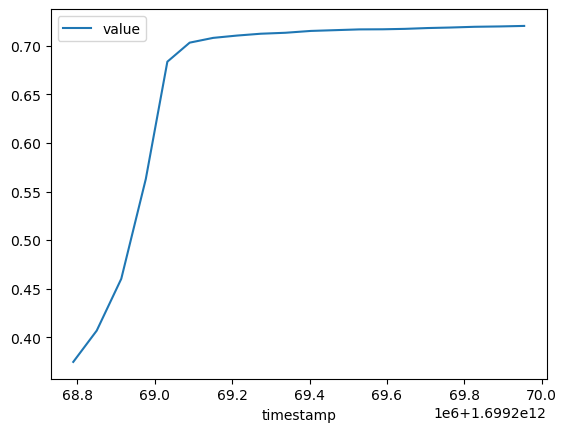

In [9]:
mllog[mllog["key"]=="eval_accuracy"][["timestamp", "value"]].plot(x="timestamp", y="value")

In [ ]:
(mllog[mllog["key"]=="block_start"]["timestamp"].min() - plot_df["start_time_ms"].values[0])/1000/60

0.39008333333333334

# Execution time

In [ ]:
jobs["duration_exec"] = (jobs["end_time_ms"] - jobs["start_time_ms"])/60000
jobs["duration_srun"] = (jobs["end_time_ms"] - jobs["srun_start_time_ms"])/60000
jobs["duration_training"] = (jobs["train_end_time_ms"] - jobs["start_time_ms"])/60000
jobs["duration_pretraining"] = jobs["duration_srun"] - jobs["duration_training"]
# training_start_time_ms

KeyError: 'end_time_ms'

### MLLOG details



In [ ]:
plot_df = jobs[(jobs["job"]==111797)]

In [ ]:
def get_block_duration(log_file):
    loglines, _ = parse_file(log_file, ruleset="2.1.0")
    mllog = pd.DataFrame(loglines)
    training_start = mllog[mllog["key"]=="block_start"].sort_values("timestamp").timestamp.values[0]
    training_end = mllog[mllog["key"]=="block_stop"].sort_values("timestamp").timestamp.values[-1]
    duration_block_ms = training_end - training_start
    return duration_block_ms/60000

jobs["duration_block_minutes"] = jobs.apply(lambda x: get_block_duration(path + "/".join(x.file.split("/")[-2:])), axis=1)

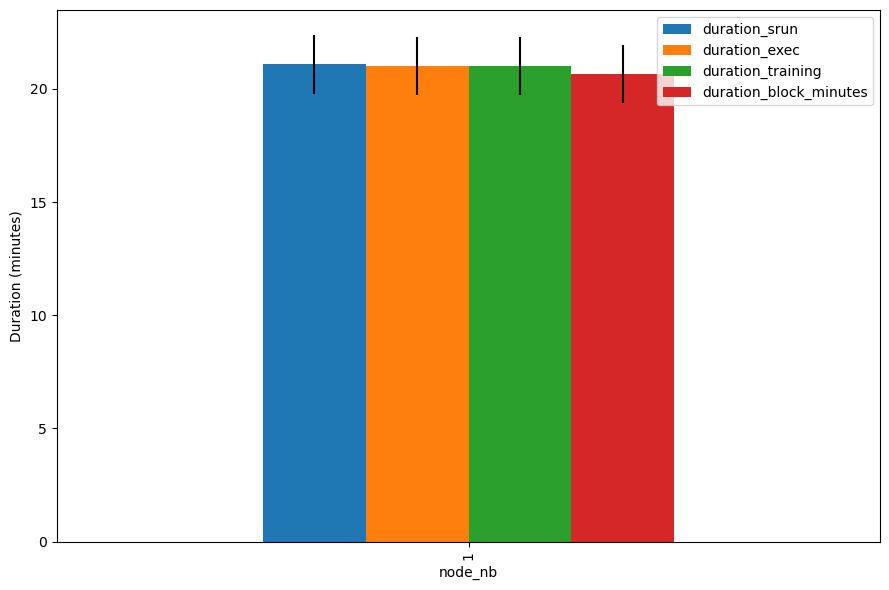

In [ ]:
plot_df = jobs[(jobs["sub_target-acc"]==0.72)&(jobs["sub_num-sample"]==14000000)]
fig, ax = plt.subplots(figsize=(9,6))
les_y = ["duration_srun", "duration_exec", "duration_training", "duration_block_minutes"]
group = plot_df.groupby("node_nb")[les_y]
group.mean().plot(
    ax=ax,
    # x="node_nb", 
    y=les_y,
    yerr=group.std()[les_y],
    kind="bar"
    )
ax.set_ylabel("Duration (minutes)")
plt.tight_layout()

duration_diff    0.422308
dtype: float64


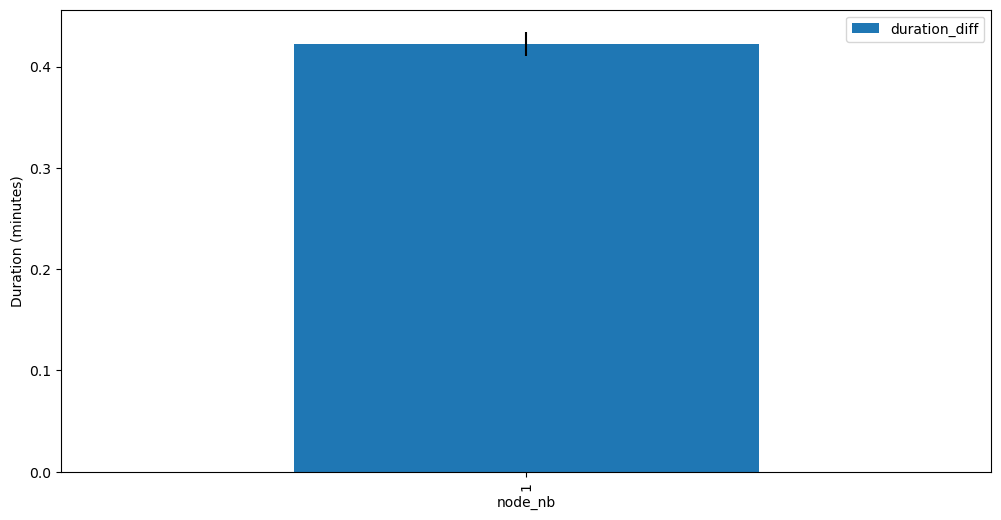

In [ ]:
plot_df = jobs[(jobs["sub_target-acc"]==0.72)&(jobs["sub_num-sample"]==14000000)]

plot_df["duration_diff"] = plot_df["duration_srun"] - plot_df["duration_block_minutes"]

fig, ax = plt.subplots(figsize=(12,6))
les_y = ["duration_diff"]
group = plot_df.groupby("node_nb")[les_y]
group.mean().plot(
    ax=ax,
    # x="node_nb", 
    y=les_y,
    yerr=group.std()[les_y],
    kind="bar"
    )
ax.set_ylabel("Duration (minutes)")
print(plot_df[les_y].mean())

As opposed to what we assumed before, the pre-processing is not significantly longer when the number of nodes increases.